In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.collections import LineCollection
mpl.rcParams["figure.dpi"] = 1000
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "mathtext.fontset": "stix",
    "font.size": 10,
    "axes.titlesize": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
})

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import multiprocessing as mp
import sys


x_end_km = 200.0
z_min_km = -40.0
min_dx_km = 2.0

dip_min_deg = 5.0
dip_max_deg = 80.0

n_profile_points = 800
s_km = np.linspace(0.0, x_end_km, n_profile_points)

x_master = np.linspace(1e-3, x_end_km, 1000)

w_blend = 15.0
structuralslip = 20.0

n_fault_dense = 1000
n_fault_nodes_inversion = 350
n_fault_nodes_final = 1000

hack_exp = 1.7
l0_m = 1_000.0

m_truth = 0.5
n_truth = 1.0

K_truth = None

target_relief_m = 1500.0

sigma_z_m = 10.0
use_length_weights = True

xctrl_true = np.array([0.0, 80.0, 120.0, 200.0], dtype=float)
zctrl_true = np.array([0.0, -10.0, -30.0, -40.0], dtype=float)

n_truth_ctrl = len(xctrl_true)

n_inv_ctrl = 4

eps = 0.01
ld_lo, ld_hi = np.log(0.5), np.log(40.0)

infer_mn = True

mlo, mhi = -0.05, 1.05 
nlo, nhi = 0.55, 1.55

snap_mn = True

rng_seed = 42
nwalkers = 100
nsteps = 5000
burn = 2500
thin = 10

USE_POOL = True
NPROC = max(1, mp.cpu_count() - 1)

print("Config loaded.")

Config loaded.


Helpers loaded.
C2 fault geometry loaded.
Kinematics loaded.
Stream-power pieces loaded.
General ctrl-point parameterization loaded.
Forward model loaded.
Truth control points:
xctrl_true = [  0.  80. 120. 200.]
zctrl_true = [  0. -10. -30. -40.]
Truth m,n = 0.5, 1.0
Truth K   = 4.958e-05
Relief (true) ~ 1500.0 m


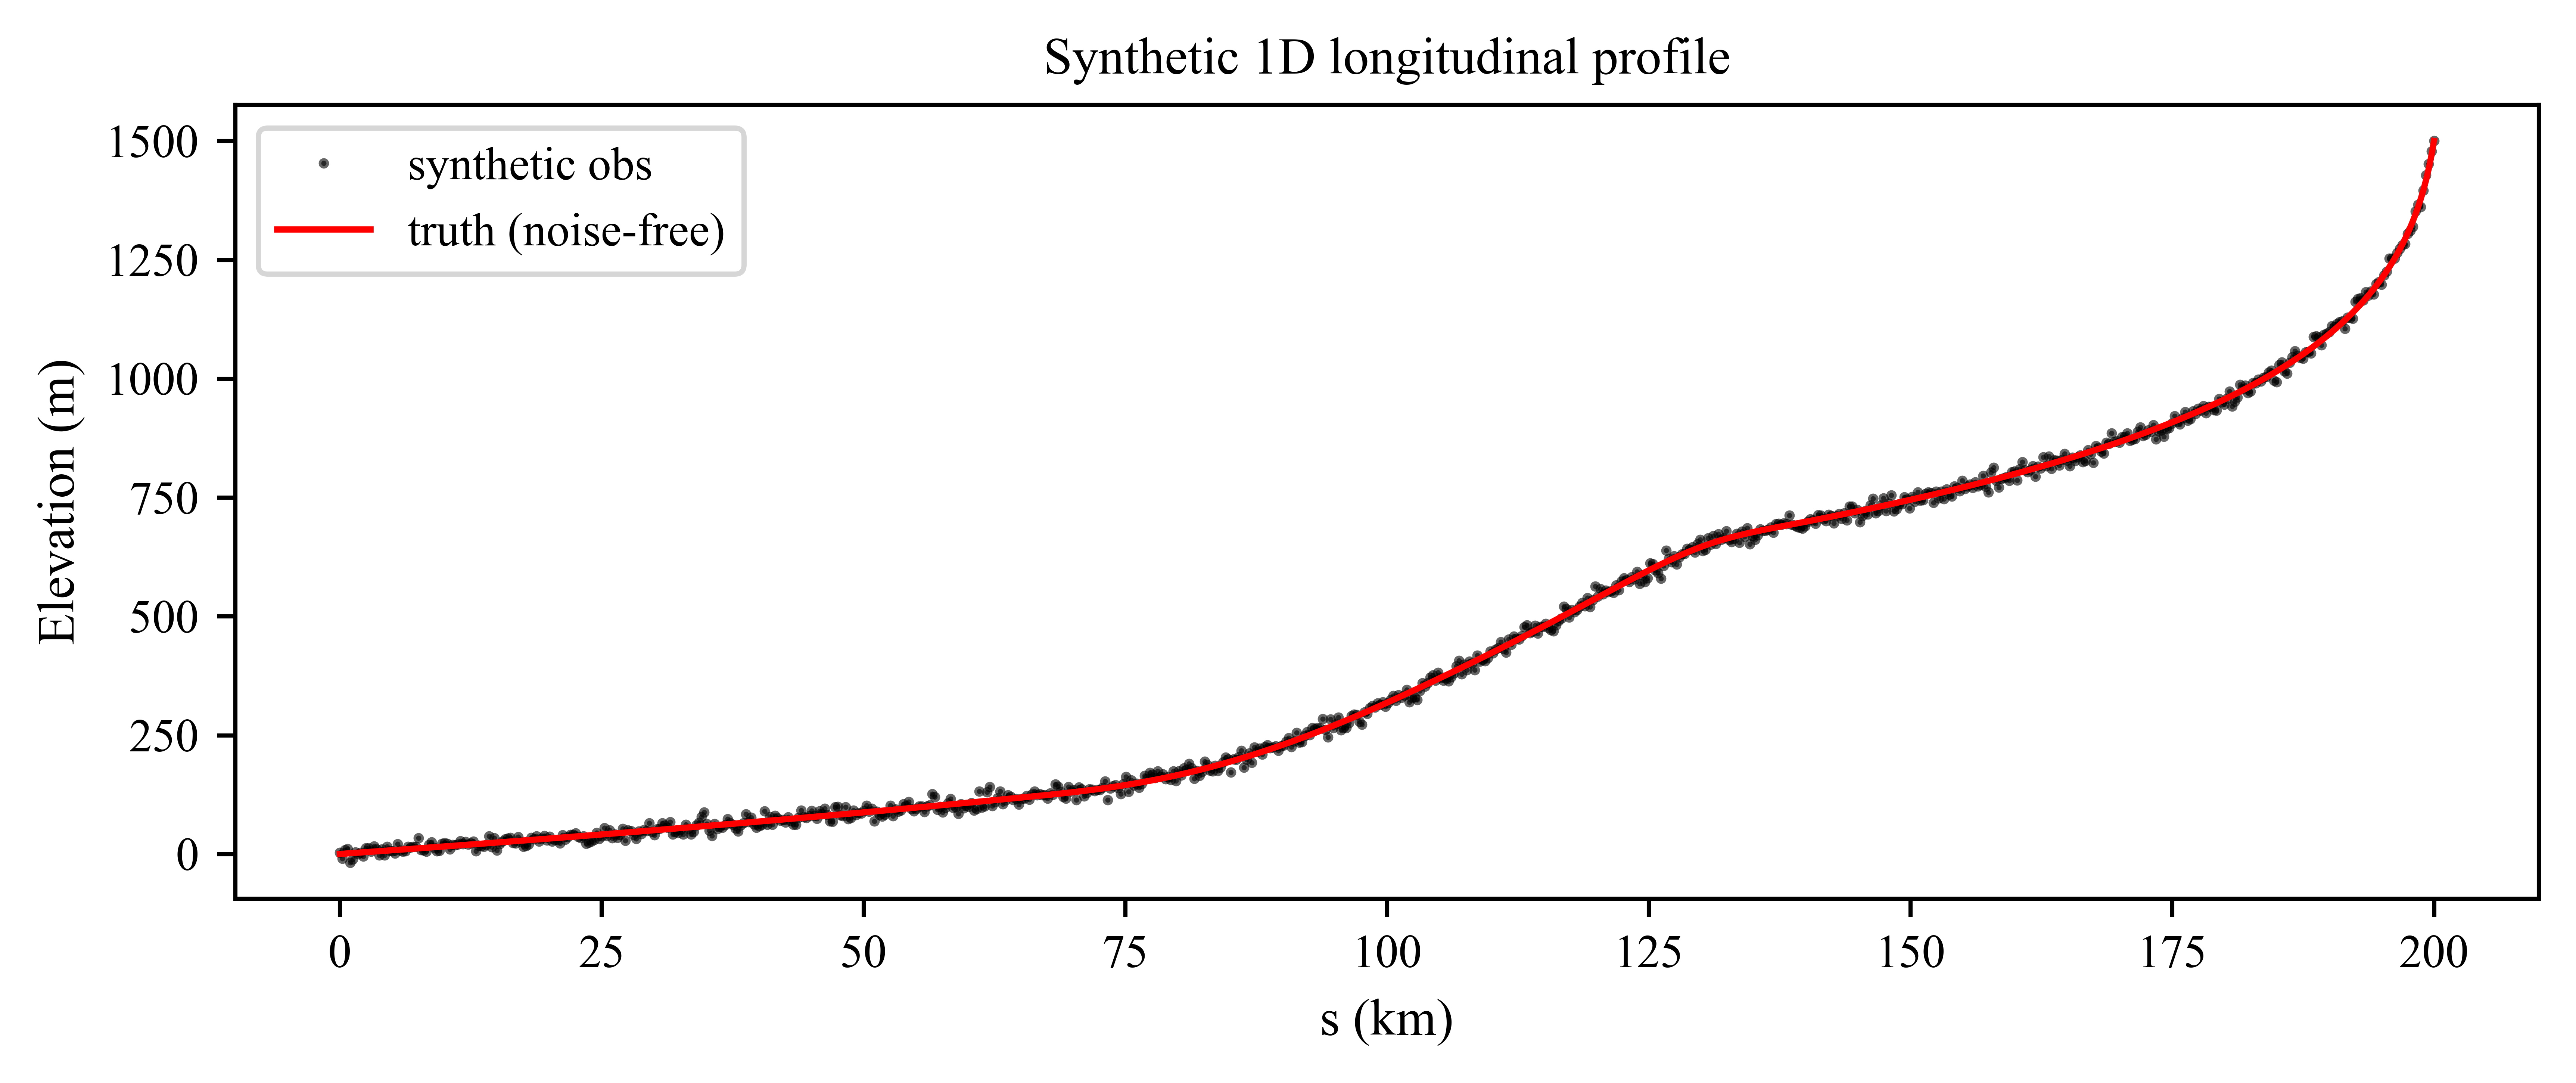

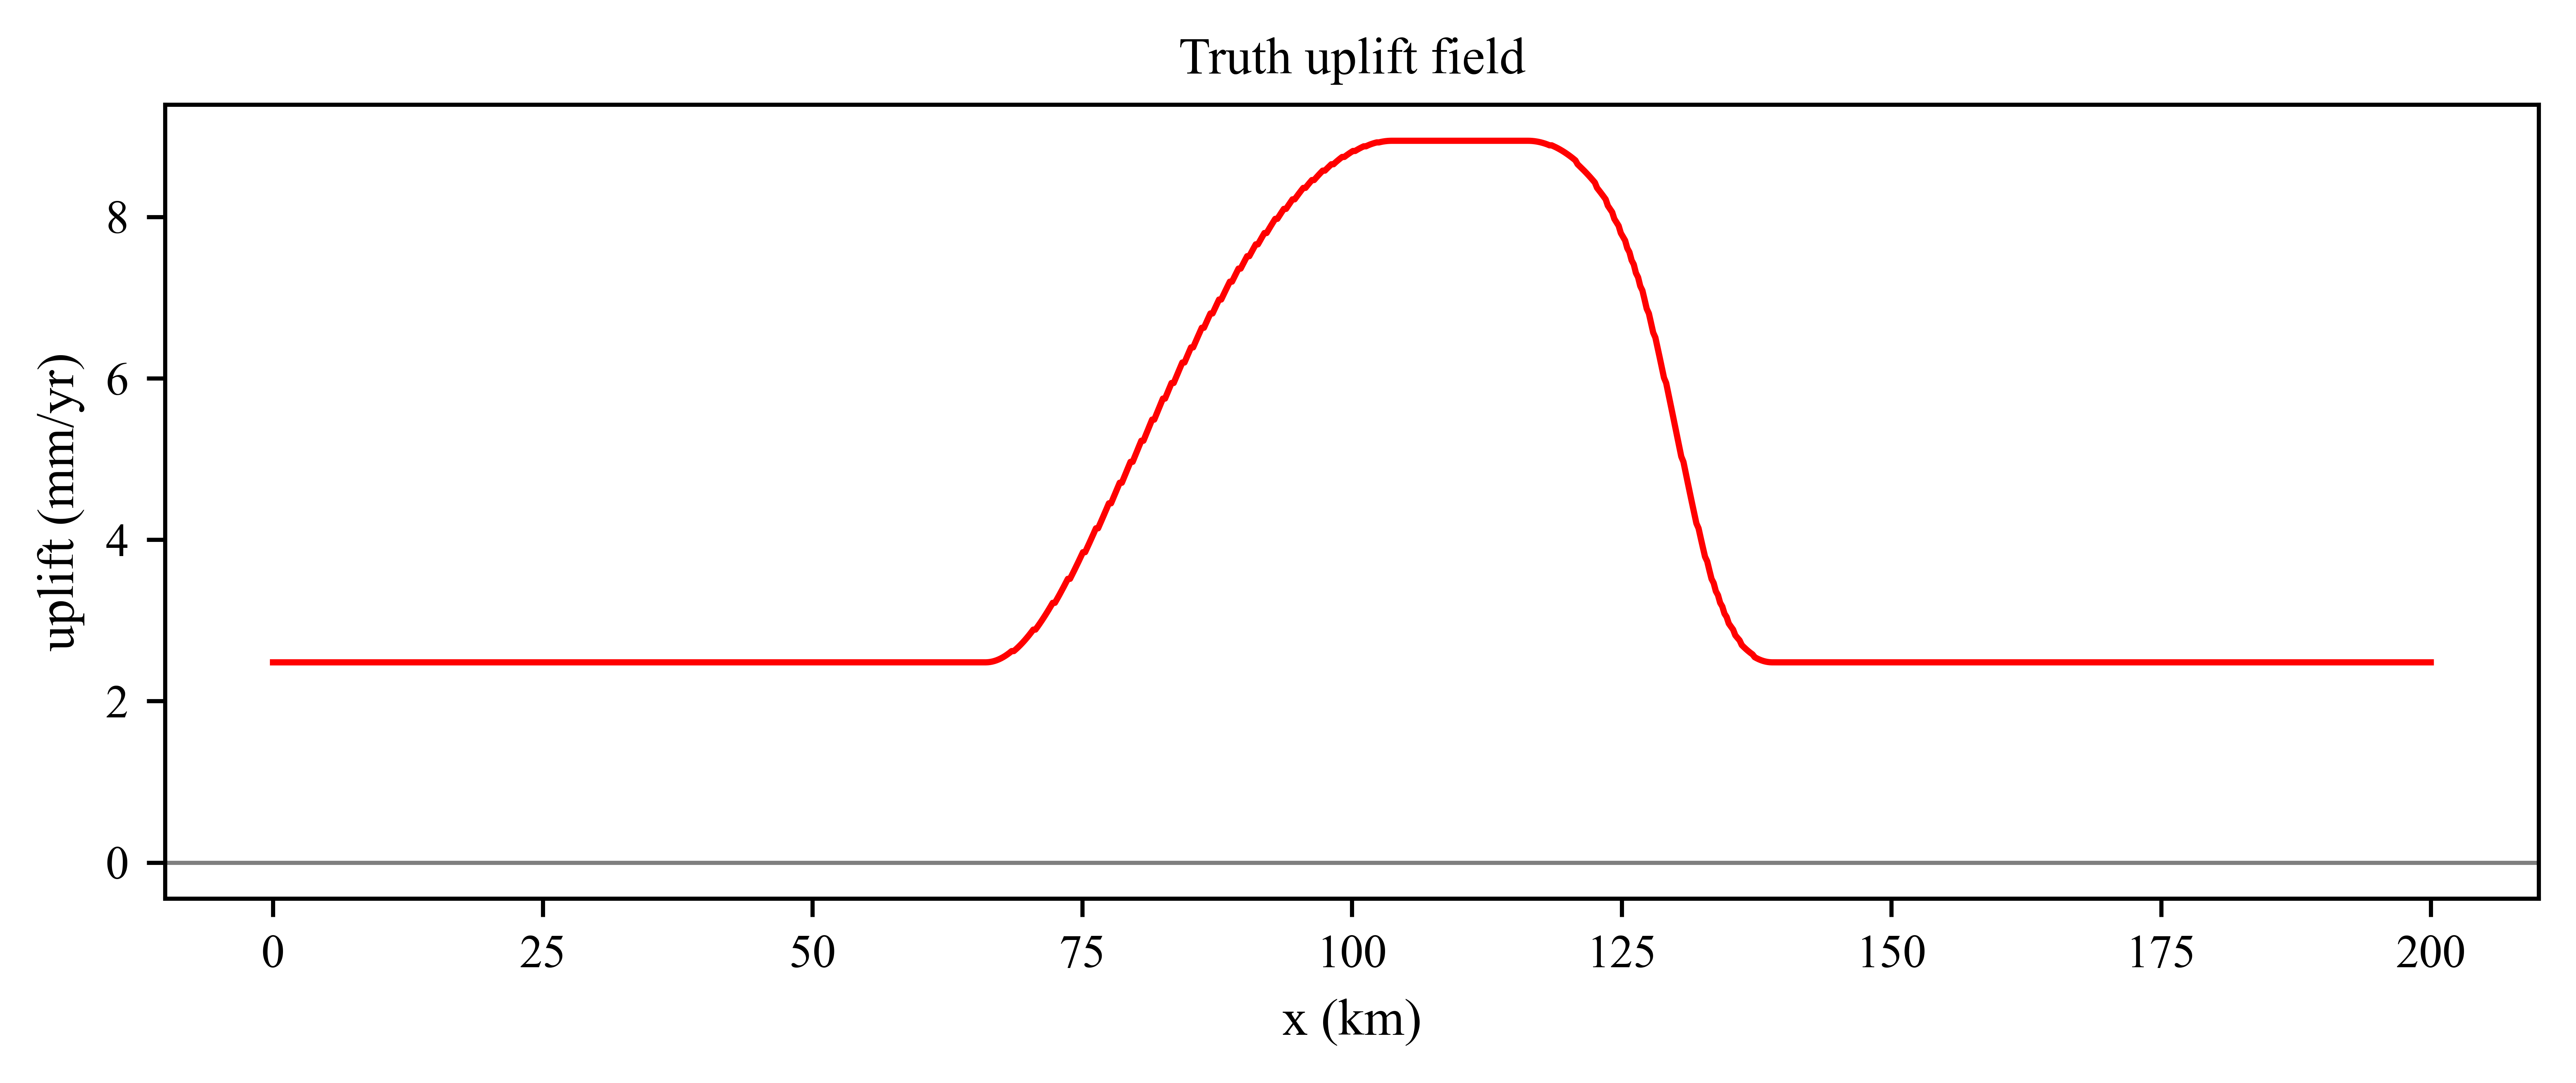

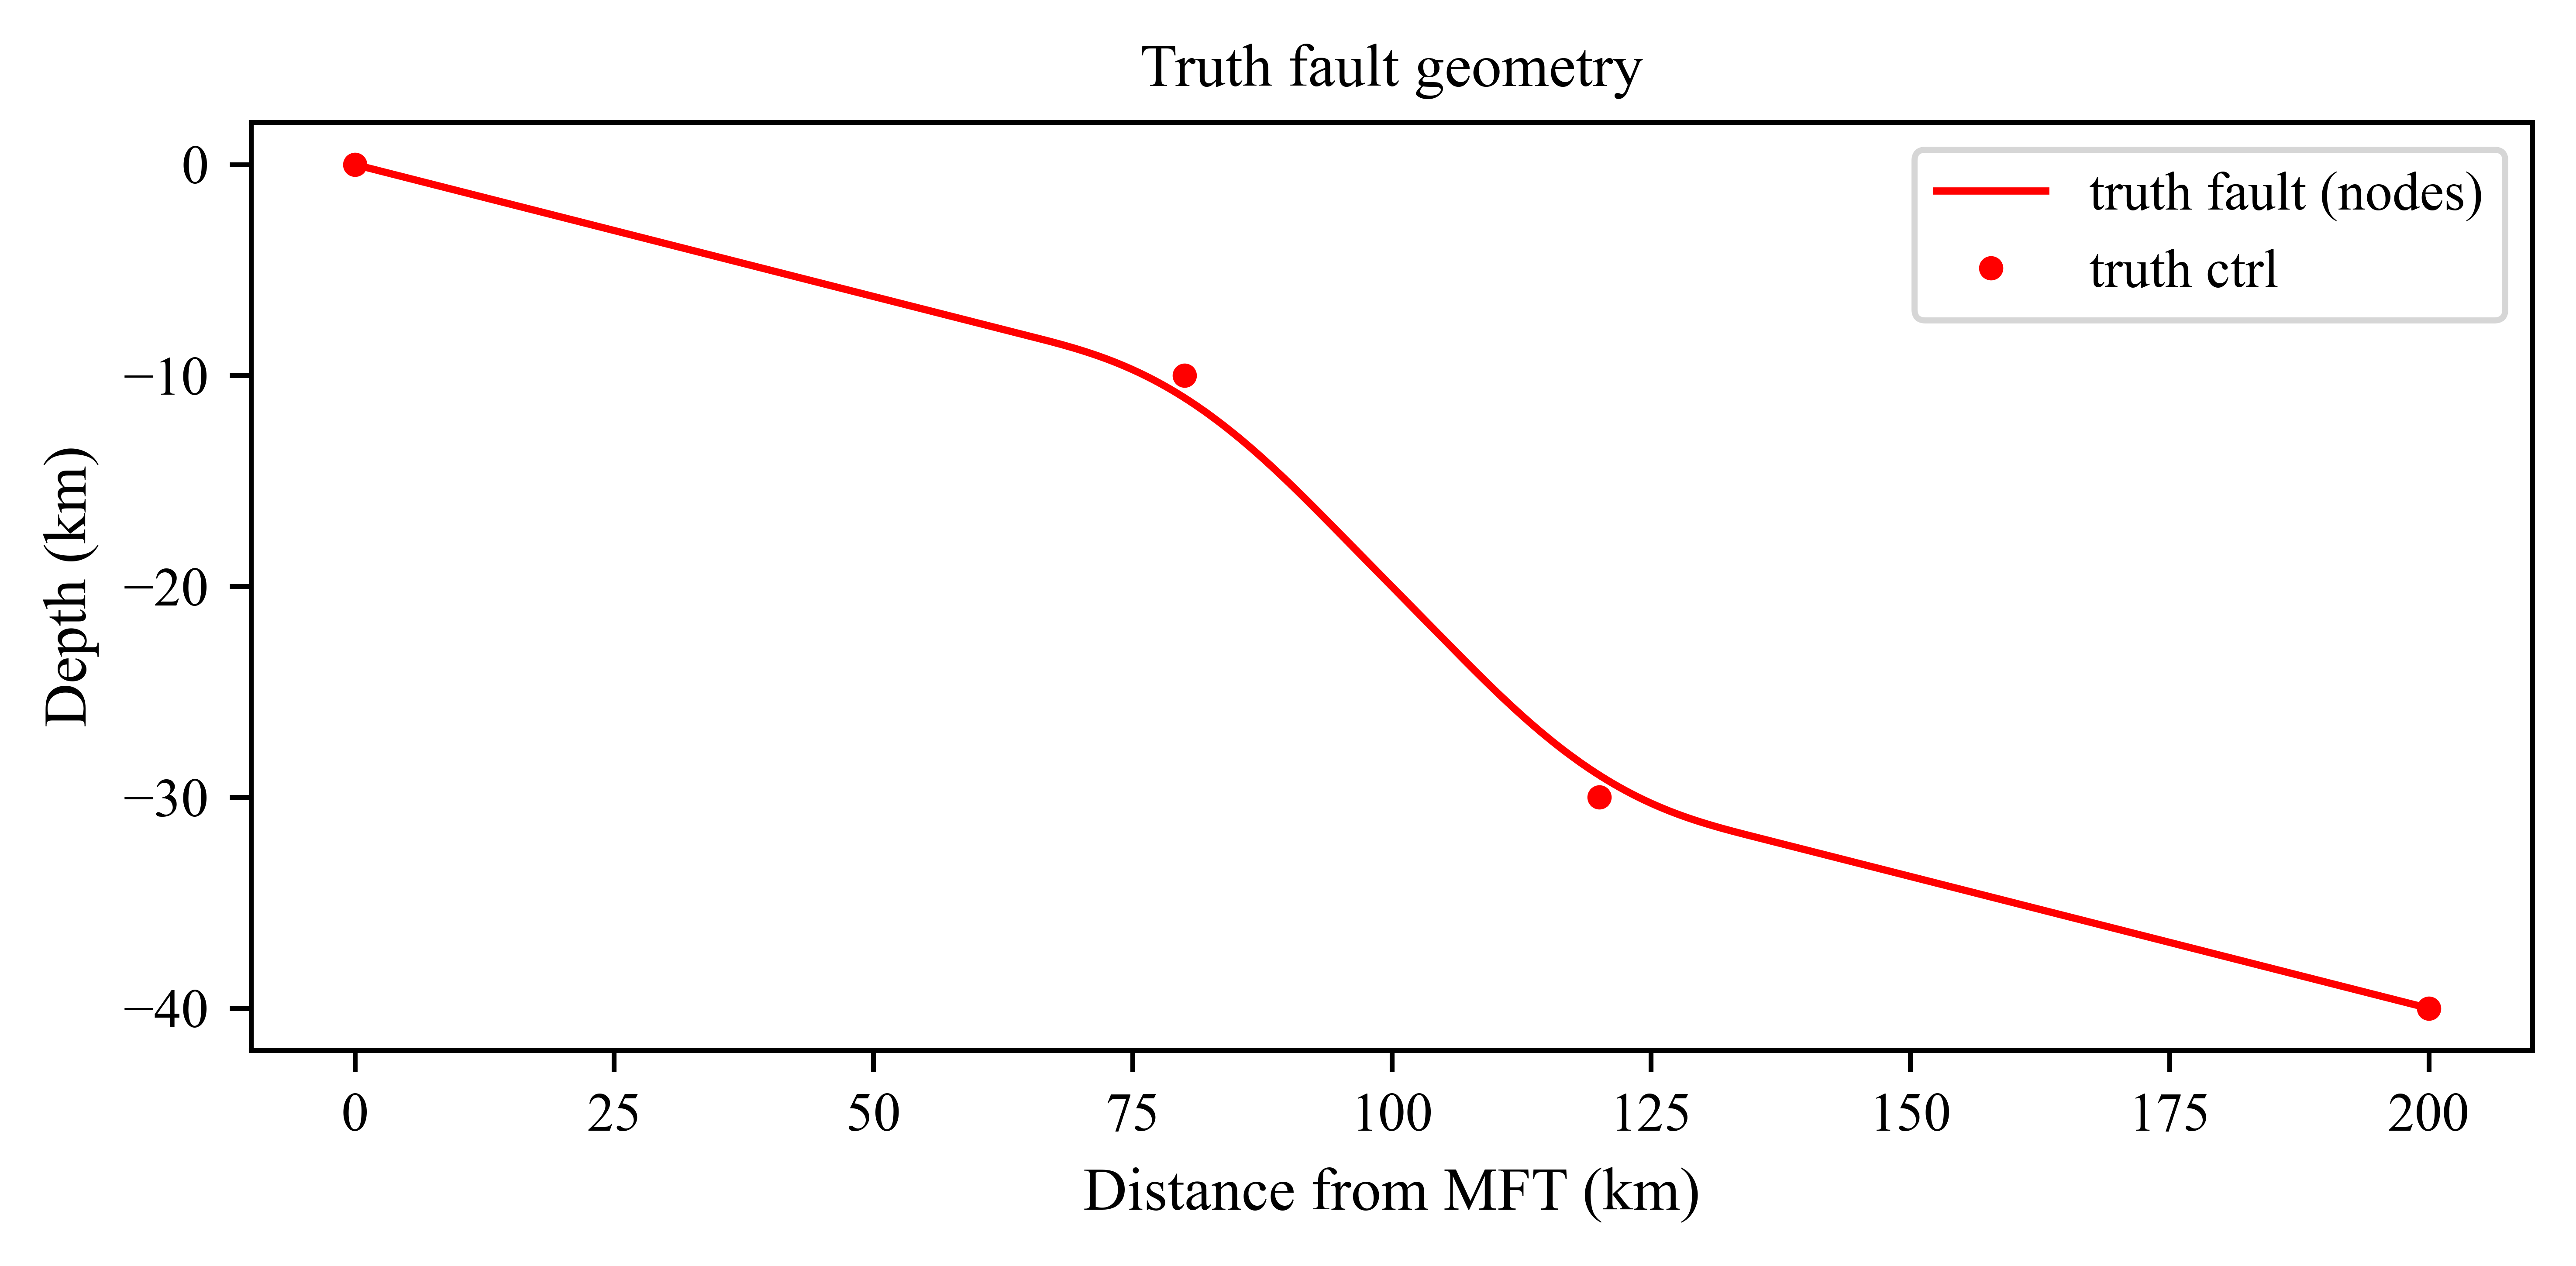

In [7]:
def interp_linear_extrap(xq, x, y):
    xq = np.asarray(xq, float)
    x  = np.asarray(x,  float)
    y  = np.asarray(y,  float)

    if np.any(np.diff(x) <= 0):
        raise ValueError("interp_linear_extrap: x must be strictly increasing")

    yq = np.interp(xq, x, y)

    left = xq < x[0]
    if np.any(left):
        mL = (y[1] - y[0]) / (x[1] - x[0])
        yq[left] = y[0] + mL * (xq[left] - x[0])

    right = xq > x[-1]
    if np.any(right):
        mR = (y[-1] - y[-2]) / (x[-1] - x[-2])
        yq[right] = y[-1] + mR * (xq[right] - x[-1])

    return yq

def length_weights_from_s(s_km):
    s_km = np.asarray(s_km, float)
    s_m = (s_km - s_km[0]) * 1000.0
    ds = np.diff(s_m)
    w = np.empty_like(s_m)
    w[0] = ds[0]
    w[-1] = ds[-1]
    w[1:-1] = 0.5 * (ds[:-1] + ds[1:])
    return w / np.mean(w)

def dips_ok(xctrl, zctrl, dip_min_deg=5.0, dip_max_deg=80.0):
    dips = np.degrees(np.arctan2(-np.diff(zctrl), np.diff(xctrl)))
    return np.all((dips > dip_min_deg) & (dips < dip_max_deg))

def validate_ctrl(xctrl, zctrl, x_end=x_end_km, z_min=z_min_km):
    xctrl = np.asarray(xctrl, float)
    zctrl = np.asarray(zctrl, float)

    if xctrl.ndim != 1 or zctrl.ndim != 1 or xctrl.size != zctrl.size:
        raise ValueError("xctrl and zctrl must be same-length 1D arrays")

    if not np.isclose(xctrl[0], 0.0) or not np.isclose(xctrl[-1], x_end):
        raise ValueError(f"xctrl endpoints must be 0 and {x_end}")

    if np.any(np.diff(xctrl) <= 0):
        raise ValueError("xctrl must be strictly increasing")

    if not np.isclose(zctrl[0], 0.0):
        raise ValueError("zctrl[0] must be 0.0")

    if np.any(np.diff(zctrl) >= 0):
        raise ValueError("zctrl must be strictly decreasing")

    if np.min(zctrl) < z_min:
        raise ValueError(f"min(zctrl) must be >= {z_min} km")

    if np.min(np.diff(xctrl)) < min_dx_km:
        raise ValueError(f"min dx must be >= {min_dx_km} km")

    if not dips_ok(xctrl, zctrl, dip_min_deg, dip_max_deg):
        raise ValueError("dips fail bounds")

    return xctrl, zctrl

w_node = length_weights_from_s(s_km) if use_length_weights else np.ones_like(s_km)
print("Helpers loaded.")

def _quintic_patch_coeffs(xL, zL, mL, xR, zR, mR):
    h = xR - xL
    if h <= 0:
        raise ValueError("xR must be > xL")
    a0 = zL
    a1 = mL * h
    a2 = 0.0
    D0 = zR - zL - a1
    D1 = (mR - mL) * h
    A = np.array([[1,  1,  1],
                  [3,  4,  5],
                  [6, 12, 20]], dtype=float)
    a3, a4, a5 = np.linalg.solve(A, np.array([D0, D1, 0.0], dtype=float))
    return np.array([a0, a1, a2, a3, a4, a5], dtype=float), h

def _eval_quintic(x, xL, coeffs, h):
    t = (x - xL) / h
    a0, a1, a2, a3, a4, a5 = coeffs
    return (((((a5 * t + a4) * t + a3) * t + a2) * t + a1) * t + a0)

def build_c2_fault_model(x, z, w=5.0):
    x = np.asarray(x, float)
    z = np.asarray(z, float)
    if np.any(np.diff(x) <= 0):
        raise ValueError("x must be strictly increasing")
    n = len(x)
    if n < 2:
        raise ValueError("Need at least 2 points")

    m_seg = np.diff(z) / np.diff(x)

    wv = np.zeros(n)
    for i in range(1, n - 1):
        wi = float(w)
        wi = min(wi, 0.45 * (x[i] - x[i - 1]), 0.45 * (x[i + 1] - x[i]))
        wv[i] = wi

    patches = {}
    for i in range(1, n - 1):
        wi = wv[i]
        if wi <= 0:
            continue
        xL = x[i] - wi
        xR = x[i] + wi
        mL = m_seg[i - 1]
        mR = m_seg[i]
        zL = z[i] + mL * (xL - x[i])
        zR = z[i] + mR * (xR - x[i])
        coeffs, h = _quintic_patch_coeffs(xL, zL, mL, xR, zR, mR)
        patches[i] = (xL, coeffs, h)

    pieces = []
    for seg in range(n - 1):
        left_cut  = wv[seg] if seg > 0 else 0.0
        right_cut = wv[seg + 1] if (seg + 1) < n - 1 else 0.0
        xL = x[seg] + left_cut
        xR = x[seg + 1] - right_cut
        if xR > xL:
            pieces.append(("line", xL, xR, seg))
        v = seg + 1
        if 1 <= v <= n - 2 and wv[v] > 0:
            pieces.append(("patch", x[v] - wv[v], x[v] + wv[v], v))

    return dict(x=x, z=z, m_seg=m_seg, pieces=pieces, patches=patches)

def eval_c2_fault(xq, model, extrapolate=True):
    x = model["x"]
    z = model["z"]
    m_seg = model["m_seg"]
    pieces = model["pieces"]
    patches = model["patches"]

    xq = np.asarray(xq, float)
    zq = np.full_like(xq, np.nan, dtype=float)

    for kind, xL, xR, idx in pieces:
        mask = (xq >= xL) & (xq <= xR)
        if not np.any(mask):
            continue
        if kind == "line":
            seg = idx
            zq[mask] = z[seg] + m_seg[seg] * (xq[mask] - x[seg])
        else:
            v = idx
            xL0, coeffs, h = patches[v]
            zq[mask] = _eval_quintic(xq[mask], xL0, coeffs, h)

    if extrapolate:
        m0 = m_seg[0]
        mn = m_seg[-1]
        zq = np.where(np.isnan(zq) & (xq < x[0]),  z[0]  + m0 * (xq - x[0]),  zq)
        zq = np.where(np.isnan(zq) & (xq > x[-1]), z[-1] + mn * (xq - x[-1]), zq)

    return zq

print("C2 fault geometry loaded.")

def resample_equal_arclength(x_dense, z_dense, n_points):
    x_dense = np.asarray(x_dense, float)
    z_dense = np.asarray(z_dense, float)
    ds = np.sqrt(np.diff(x_dense) ** 2 + np.diff(z_dense) ** 2)
    s = np.concatenate(([0.0], np.cumsum(ds)))
    L = s[-1]
    s_uniform = np.linspace(0.0, L, int(n_points))
    x_new = np.interp(s_uniform, s, x_dense)
    z_new = np.interp(s_uniform, s, z_dense)
    return x_new, z_new, s_uniform, L

def segment_angles(xnode, znode):
    xnode = np.asarray(xnode, dtype=float)
    znode = np.asarray(znode, dtype=float)
    dx = np.diff(xnode)
    dz = np.diff(znode)
    theta = np.arctan2(dz, dx)
    return theta, dx, dz

def compute_axial_surface_intersections(xnode, znode, theta, atol=1e-12):
    xnode = np.asarray(xnode, dtype=float)
    znode = np.asarray(znode, dtype=float)
    theta = np.asarray(theta, dtype=float)

    nseg = theta.size
    x_axial = np.empty(nseg - 1, dtype=float)
    gamma = np.empty(nseg - 1, dtype=float)

    for j in range(1, nseg):
        th1 = theta[j - 1]
        th2 = theta[j]
        g = 0.5 * (th1 + th2 + np.pi)
        gamma[j - 1] = g

        xk, zk = xnode[j], znode[j]
        tg = np.tan(g)
        if np.isclose(tg, 0.0, atol=atol):
            x_axial[j - 1] = np.nan
        else:
            x_axial[j - 1] = xk - zk / tg

    x_bounds = x_axial[np.isfinite(x_axial)]
    bad = np.where(np.diff(x_bounds) <= 0)[0]
    if bad.size:
        i = bad[0]
        raise ValueError(f"x_axial not strictly increasing at i={i}")

    return x_axial, gamma

def structural_velocity(x_obs, theta, x_axial, slip_by_segment, x_start):
    x_obs = np.asarray(x_obs, dtype=float)
    theta = np.asarray(theta, dtype=float)
    slip_by_segment = np.asarray(slip_by_segment, dtype=float)
    x_axial = np.asarray(x_axial, dtype=float)

    x_bounds = x_axial[np.isfinite(x_axial)]
    dom = np.searchsorted(x_bounds, x_obs, side="right")
    dom = np.clip(dom, 0, theta.size - 1)

    u = slip_by_segment[dom] * np.cos(theta[dom])
    v = -slip_by_segment[dom] * np.sin(theta[dom])

    mask = x_obs < x_start
    u = u.astype(float, copy=True)
    v = v.astype(float, copy=True)
    u[mask] = 0.0
    v[mask] = 0.0
    return u, v, dom

print("Kinematics loaded.")


def precompute_streampower_geometry_terms(x_km, hack_exp, l0_m):
    x_km = np.asarray(x_km, float)
    s_m = (x_km - x_km[0]) * 1000.0
    ds_m = np.diff(s_m)
    L_m = float(s_m[-1])
    l_to_divide_m = L_m - s_m
    A_proxy = (l_to_divide_m + float(l0_m)) ** float(hack_exp)
    A_mid = 0.5 * (A_proxy[:-1] + A_proxy[1:])
    return ds_m, A_mid

def stream_power_integral_I_from_uplift(uplift_mm_yr, ds_m, A_mid, m_sp, n_sp):
    U_m_yr = np.maximum(np.asarray(uplift_mm_yr, float) / 1000.0, 0.0)
    U_mid = 0.5 * (U_m_yr[:-1] + U_m_yr[1:])

    integrand = np.zeros_like(U_mid)
    mask = U_mid > 0.0
    if np.any(mask):
        integrand[mask] = (U_mid[mask] / (A_mid[mask] ** float(m_sp))) ** (1.0 / float(n_sp))

    I = np.concatenate(([0.0], np.cumsum(integrand * ds_m)))
    return I

def fit_K_given_baselevel(I, z_obs, n_sp):
    I = np.asarray(I, float)
    z_obs = np.asarray(z_obs, float)
    z0 = float(z_obs[0])
    y = z_obs - z0

    denom = float(np.dot(I, I))
    if denom <= 0 or not np.isfinite(denom):
        return np.nan, np.full_like(z_obs, np.nan), np.nan

    a = float(np.dot(I, y) / denom)  # a = K^(-1/n)
    if a <= 0 or not np.isfinite(a):
        return np.nan, np.full_like(z_obs, np.nan), z0

    K = a ** (-float(n_sp))
    z_pred = z0 + a * I
    return K, z_pred, z0

ds_m_fixed, A_mid_fixed = precompute_streampower_geometry_terms(s_km, hack_exp=hack_exp, l0_m=l0_m)
print("Stream-power pieces loaded.")

def params_to_fault_ctrl_general(p_fault, n_ctrl, x_end=x_end_km):
    """
    p_fault = [q1..q_{n_ctrl-2}, ld1..ld_{n_ctrl-1}]

    x control points:
      x0 = 0
      x_i = x_{i-1} + q_i*(x_end - x_{i-1})   for i=1..n_ctrl-2
      x_{n_ctrl-1} = x_end

    z control points:
      d_j = exp(ld_j) for j=1..n_ctrl-1
      z0 = 0
      z_k = -sum_{j<=k} d_j  for k=1..n_ctrl-1
    """
    p_fault = np.asarray(p_fault, float)
    nq = n_ctrl - 2
    nd = n_ctrl - 1
    if p_fault.size != nq + nd:
        raise ValueError("wrong p_fault size")

    qs = p_fault[:nq]
    lds = p_fault[nq:]

    x = np.empty(n_ctrl, dtype=float)
    x[0] = 0.0
    x_prev = 0.0
    for i, q in enumerate(qs, start=1):
        x_prev = x_prev + (x_end - x_prev) * float(q)
        x[i] = x_prev
    x[-1] = float(x_end)

    d = np.exp(lds)
    z_interior = -np.cumsum(d)
    z = np.concatenate(([0.0], z_interior))
    return x, z

def draw_random_ctrl(n_ctrl, rng):
    nq = n_ctrl - 2
    nd = n_ctrl - 1
    for _ in range(20000):
        qs  = rng.uniform(eps, 1.0 - eps, size=nq)
        lds = rng.uniform(ld_lo, ld_hi, size=nd)
        x, z = params_to_fault_ctrl_general(np.r_[qs, lds], n_ctrl=n_ctrl, x_end=x_end_km)
        if np.min(np.diff(x)) < min_dx_km:
            continue
        if np.min(z) < z_min_km:
            continue
        if not dips_ok(x, z, dip_min_deg, dip_max_deg):
            continue
        return x, z
    raise RuntimeError("Failed to draw valid control points; relax constraints.")

def snap(m_raw, n_raw):
    # same snapping behavior as your code
    m_idx = int(np.floor(m_raw * 10.0 + 0.5))
    m_idx = int(np.clip(m_idx, 0, 20))
    n_idx = int(np.floor(n_raw * 10.0 + 0.5))
    n_idx = int(np.clip(n_idx, 1, 20))
    return m_idx / 10.0, n_idx / 10.0

print("General ctrl-point parameterization loaded.")

def compute_uplift_from_fault(xctrl, zctrl, n_dense=600, n_nodes=350):
    m = build_c2_fault_model(xctrl, zctrl, w=w_blend)

    xd = np.linspace(xctrl[0], xctrl[-1], int(n_dense))
    zd = eval_c2_fault(xd, m)

    xn, zn, _, _ = resample_equal_arclength(xd, zd, int(n_nodes))
    th, _, _ = segment_angles(xn, zn)
    xa, _ = compute_axial_surface_intersections(xn, zn, th)

    _, v, _ = structural_velocity(
        x_master, th, xa,
        structuralslip*np.ones_like(th),
        x_start=xn[0]
    )
    return v, (xn, zn)

def forward_model_onepass(p_fault, m_sp, n_sp, z_obs, n_ctrl,
                          n_dense=n_fault_dense, n_nodes=n_fault_nodes_inversion):
    # ctrl points from parameters
    xctrl, zctrl = params_to_fault_ctrl_general(p_fault, n_ctrl=n_ctrl, x_end=x_end_km)

    # geometry constraints
    if np.min(np.diff(xctrl)) < min_dx_km:
        return None
    if np.min(zctrl) < z_min_km:
        return None
    if not dips_ok(xctrl, zctrl, dip_min_deg, dip_max_deg):
        return None

    try:
        uplift_mm_yr, (xnode, znode) = compute_uplift_from_fault(
            xctrl, zctrl, n_dense=n_dense, n_nodes=n_nodes
        )
    except Exception:
        return None

    if np.min(znode) < z_min_km:
        return None

    # In this 1D synthetic setup, sample uplift along s_km (same axis length as river)
    uplift_on_channel = interp_linear_extrap(s_km, x_master, uplift_mm_yr)

    I = stream_power_integral_I_from_uplift(
        uplift_on_channel, ds_m_fixed, A_mid_fixed, m_sp, n_sp
    )

    K_fit, z_pred, z0 = fit_K_given_baselevel(I, z_obs, n_sp=n_sp)
    if not np.isfinite(K_fit):
        return None

    return dict(
        xctrl=xctrl, zctrl=zctrl,
        xnode=xnode, znode=znode,
        uplift_mm_yr=uplift_mm_yr,
        uplift_on_channel=uplift_on_channel,
        I=I, K_fit=K_fit, z_pred=z_pred, z0=z0
    )

print("Forward model loaded.")

rng = np.random.default_rng(rng_seed)

# Truth control points (your "parameter of x and zctrl")
if (xctrl_true is None) or (zctrl_true is None):
    xT, zT = draw_random_ctrl(n_truth_ctrl, rng)
else:
    xT, zT = validate_ctrl(xctrl_true, zctrl_true, x_end=x_end_km, z_min=z_min_km)

print("Truth control points:")
print("xctrl_true =", xT)
print("zctrl_true =", zT)

# Compute truth uplift and I using truth geometry
uplift_true, (xnode_T, znode_T) = compute_uplift_from_fault(
    xT, zT, n_dense=n_fault_dense, n_nodes=n_fault_nodes_final
)
uplift_on_channel_true = interp_linear_extrap(s_km, x_master, uplift_true)
I_true = stream_power_integral_I_from_uplift(
    uplift_on_channel_true, ds_m_fixed, A_mid_fixed, m_truth, n_truth
)

# Choose K_truth if None using target relief
I_end = float(I_true[-1]) if (np.isfinite(I_true[-1]) and I_true[-1] > 0) else 1.0

if K_truth is None:
    a_true = target_relief_m / I_end           # a = K^{-1/n}
    K_truth_used = a_true ** (-n_truth)
else:
    K_truth_used = float(K_truth)
    a_true = K_truth_used ** (-1.0 / n_truth)

Z_true = 0.0 + a_true * I_true
Z_obs  = Z_true + rng.normal(0.0, sigma_z_m, size=Z_true.size)

print(f"Truth m,n = {m_truth}, {n_truth}")
print(f"Truth K   = {K_truth_used:.3e}")
print(f"Relief (true) ~ {Z_true[-1]-Z_true[0]:.1f} m")

# Plot synthetic profile
plt.figure(figsize=(7,3))
plt.plot(s_km, Z_obs, "k.", ms=2, alpha=0.6, label="synthetic obs")
plt.plot(s_km, Z_true, "r-", lw=1.2, label="truth (noise-free)")
plt.xlabel("s (km)")
plt.ylabel("Elevation (m)")
plt.title("Synthetic 1D longitudinal profile")
plt.legend()
plt.tight_layout()
plt.show()

# Plot truth uplift
plt.figure(figsize=(7,3))
plt.plot(x_master, uplift_true, "r-", lw=1.2)
plt.axhline(0.0, color="k", lw=0.8, alpha=0.5)
plt.xlabel("x (km)")
plt.ylabel("uplift (mm/yr)")
plt.title("Truth uplift field")
plt.tight_layout()
plt.show()

# Plot truth fault geometry
plt.figure(figsize=(6,3))
plt.plot(xnode_T, znode_T, "r-", lw=1.2, label="truth fault (nodes)")
plt.plot(xT, zT, "ro", ms=3, label="truth ctrl")
plt.xlabel("Distance from MFT (km)")
plt.ylabel("Depth (km)")
plt.title("Truth fault geometry")
plt.legend()
plt.tight_layout()
plt.show()




In [8]:
# Dimensions for inversion parameterization
nq = n_inv_ctrl - 2
nd = n_inv_ctrl - 1
ndim_fault = nq + nd
ndim = ndim_fault + (2 if infer_mn else 0)

def unpack_theta(theta):
    theta = np.asarray(theta, float)
    if infer_mn:
        p_fault = theta[:ndim_fault]
        m_raw, n_raw = float(theta[ndim_fault]), float(theta[ndim_fault+1])
        return p_fault, m_raw, n_raw
    else:
        return theta[:ndim_fault], None, None

def log_prior(theta):
    p_fault, m_raw, n_raw = unpack_theta(theta)

    qs  = p_fault[:nq]
    lds = p_fault[nq:]

    # q bounds
    if np.any(qs <= eps) or np.any(qs >= 1.0 - eps):
        return -np.inf

    # ld bounds
    if np.any(lds <= ld_lo) or np.any(lds >= ld_hi):
        return -np.inf

    # m,n bounds (raw)
    if infer_mn:
        if not (mlo <= m_raw <= mhi):
            return -np.inf
        if not (nlo <= n_raw <= nhi):
            return -np.inf

    # geometry constraints
    xctrl, zctrl = params_to_fault_ctrl_general(p_fault, n_ctrl=n_inv_ctrl, x_end=x_end_km)
    if np.min(np.diff(xctrl)) < min_dx_km:
        return -np.inf
    if np.min(zctrl) < z_min_km:
        return -np.inf
    if not dips_ok(xctrl, zctrl, dip_min_deg, dip_max_deg):
        return -np.inf

    return 0.0

def log_likelihood(theta, Zobs):
    p_fault, m_raw, n_raw = unpack_theta(theta)

    if infer_mn:
        m_use, n_use = (snap(m_raw, n_raw) if snap_mn else (m_raw, n_raw))
    else:
        m_use, n_use = m_truth, n_truth

    out = forward_model_onepass(
        p_fault, m_sp=m_use, n_sp=n_use,
        z_obs=Zobs, n_ctrl=n_inv_ctrl,
        n_dense=n_fault_dense, n_nodes=n_fault_nodes_inversion
    )
    if out is None:
        return -np.inf

    r = Zobs - out["z_pred"]
    chi2 = np.sum(w_node * (r / float(sigma_z_m))**2)
    return -0.5 * float(chi2)

def log_probability(theta, Zobs):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta, Zobs)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll

# Initialize walkers by drawing from prior until valid
rng = np.random.default_rng(rng_seed)

def draw_valid():
    while True:
        qs  = rng.uniform(eps, 1.0 - eps, size=nq)
        lds = rng.uniform(ld_lo, ld_hi, size=nd)
        if infer_mn:
            m_raw = rng.uniform(mlo, mhi)
            n_raw = rng.uniform(nlo, nhi)
            th = np.r_[qs, lds, m_raw, n_raw].astype(float)
        else:
            th = np.r_[qs, lds].astype(float)

        if np.isfinite(log_probability(th, Z_obs)):
            return th

p0 = np.vstack([draw_valid() for _ in range(nwalkers)])

print(f"Running emcee with ndim={ndim}, nwalkers={nwalkers}, nsteps={nsteps}")
print(f"n_inv_ctrl={n_inv_ctrl}, infer_mn={infer_mn}, snap_mn={snap_mn}")

if USE_POOL:
    if sys.platform == "darwin":
        ctx = mp.get_context("fork")
    else:
        ctx = mp.get_context()
    with ctx.Pool(processes=NPROC) as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(Z_obs,), pool=pool)
        sampler.run_mcmc(p0, nsteps, progress=True)
else:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(Z_obs,))
    sampler.run_mcmc(p0, nsteps, progress=True)

print("Done.")


Running emcee with ndim=7, nwalkers=100, nsteps=5000
n_inv_ctrl=4, infer_mn=True, snap_mn=True


100%|██████████| 5000/5000 [01:50<00:00, 45.26it/s]

Done.


In [12]:
flat_s  = sampler.get_chain(discard=burn, thin=thin, flat=True)

# 1) coordinate-wise posterior median in parameter space
th_med = np.nanmedian(flat_s, axis=0)

# 2) evaluate; if invalid, pick the nearest valid posterior sample
def eval_theta(theta, n_nodes):
    p, mr, nr = unpack_theta(theta)
    if infer_mn:
        m_use, n_use = (snap(mr, nr) if snap_mn else (mr, nr))
    else:
        m_use, n_use = m_truth, n_truth
    out = forward_model_onepass(
        p, m_sp=m_use, n_sp=n_use,
        z_obs=Z_obs, n_ctrl=n_inv_ctrl,
        n_dense=n_fault_dense, n_nodes=n_nodes
    )
    return out, m_use, n_use

best_med, m_med, n_med = eval_theta(th_med, n_fault_nodes_final)

if best_med is None:
    d2 = np.sum((flat_s - th_med)**2, axis=1)
    order = np.argsort(d2)
    best_med = None
    for k in order:
        cand = flat_s[k]
        out, m_use, n_use = eval_theta(cand, n_fault_nodes_final)
        if out is not None:
            th_med = cand
            best_med, m_med, n_med = out, m_use, n_use
            break
    if best_med is None:
        raise RuntimeError("Could not find a valid posterior sample near the parameter-wise median.")

print("Median-parameter theta (or nearest valid sample):", th_med)
print(f"Median-parameter m,n (used) = {m_med:.2f}, {n_med:.2f}")
print(f"Median-parameter K_fit (analytic) = {best_med['K_fit']:.3e}")


Median-parameter theta (or nearest valid sample): [0.4025054  0.32704455 2.25905514 2.88178417 2.37406965 0.46405261
 1.0575606 ]
Median-parameter m,n (used) = 0.50, 1.10
Median-parameter K_fit (analytic) = 7.860e-05


In [13]:
# ----------------------------------------
# Build posterior predictive draw storage
# ----------------------------------------
flat_s = sampler.get_chain(discard=burn, thin=thin, flat=True)

nsample_plot = 100
rng = np.random.default_rng(0)

pred_draws = []
uplift_draws = []
fault_draws = []

tries = 0
max_tries = 50000

while len(pred_draws) < nsample_plot and tries < max_tries:
    tries += 1

    th = flat_s[rng.integers(0, len(flat_s))]
    p, mr, nr = unpack_theta(th)

    if infer_mn:
        m_use, n_use = (snap(mr, nr) if snap_mn else (mr, nr))
    else:
        m_use, n_use = m_truth, n_truth

    out = forward_model_onepass(
        p, m_sp=m_use, n_sp=n_use,
        z_obs=Z_obs, n_ctrl=n_inv_ctrl,
        n_dense=1000, n_nodes=n_fault_nodes_inversion
    )

    if out is None:
        continue

    pred_draws.append(out["z_pred"])
    uplift_draws.append(out["uplift_mm_yr"])
    fault_draws.append((out["xnode"], out["znode"]))

if len(pred_draws) < nsample_plot:
    raise RuntimeError("Could not collect enough valid posterior samples.")

pred_draws = np.asarray(pred_draws)
uplift_draws = np.asarray(uplift_draws)

print(f"Collected {len(pred_draws)} posterior predictive draws.")

z_med = np.median(pred_draws, axis=0)

# Uplift median (pointwise)
u_med = np.median(uplift_draws, axis=0)

Collected 100 posterior predictive draws.


/var/folders/pr/qny_rwwj2256n07fx_ml0r500000gn/T/ipykernel_99634/3460632501.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


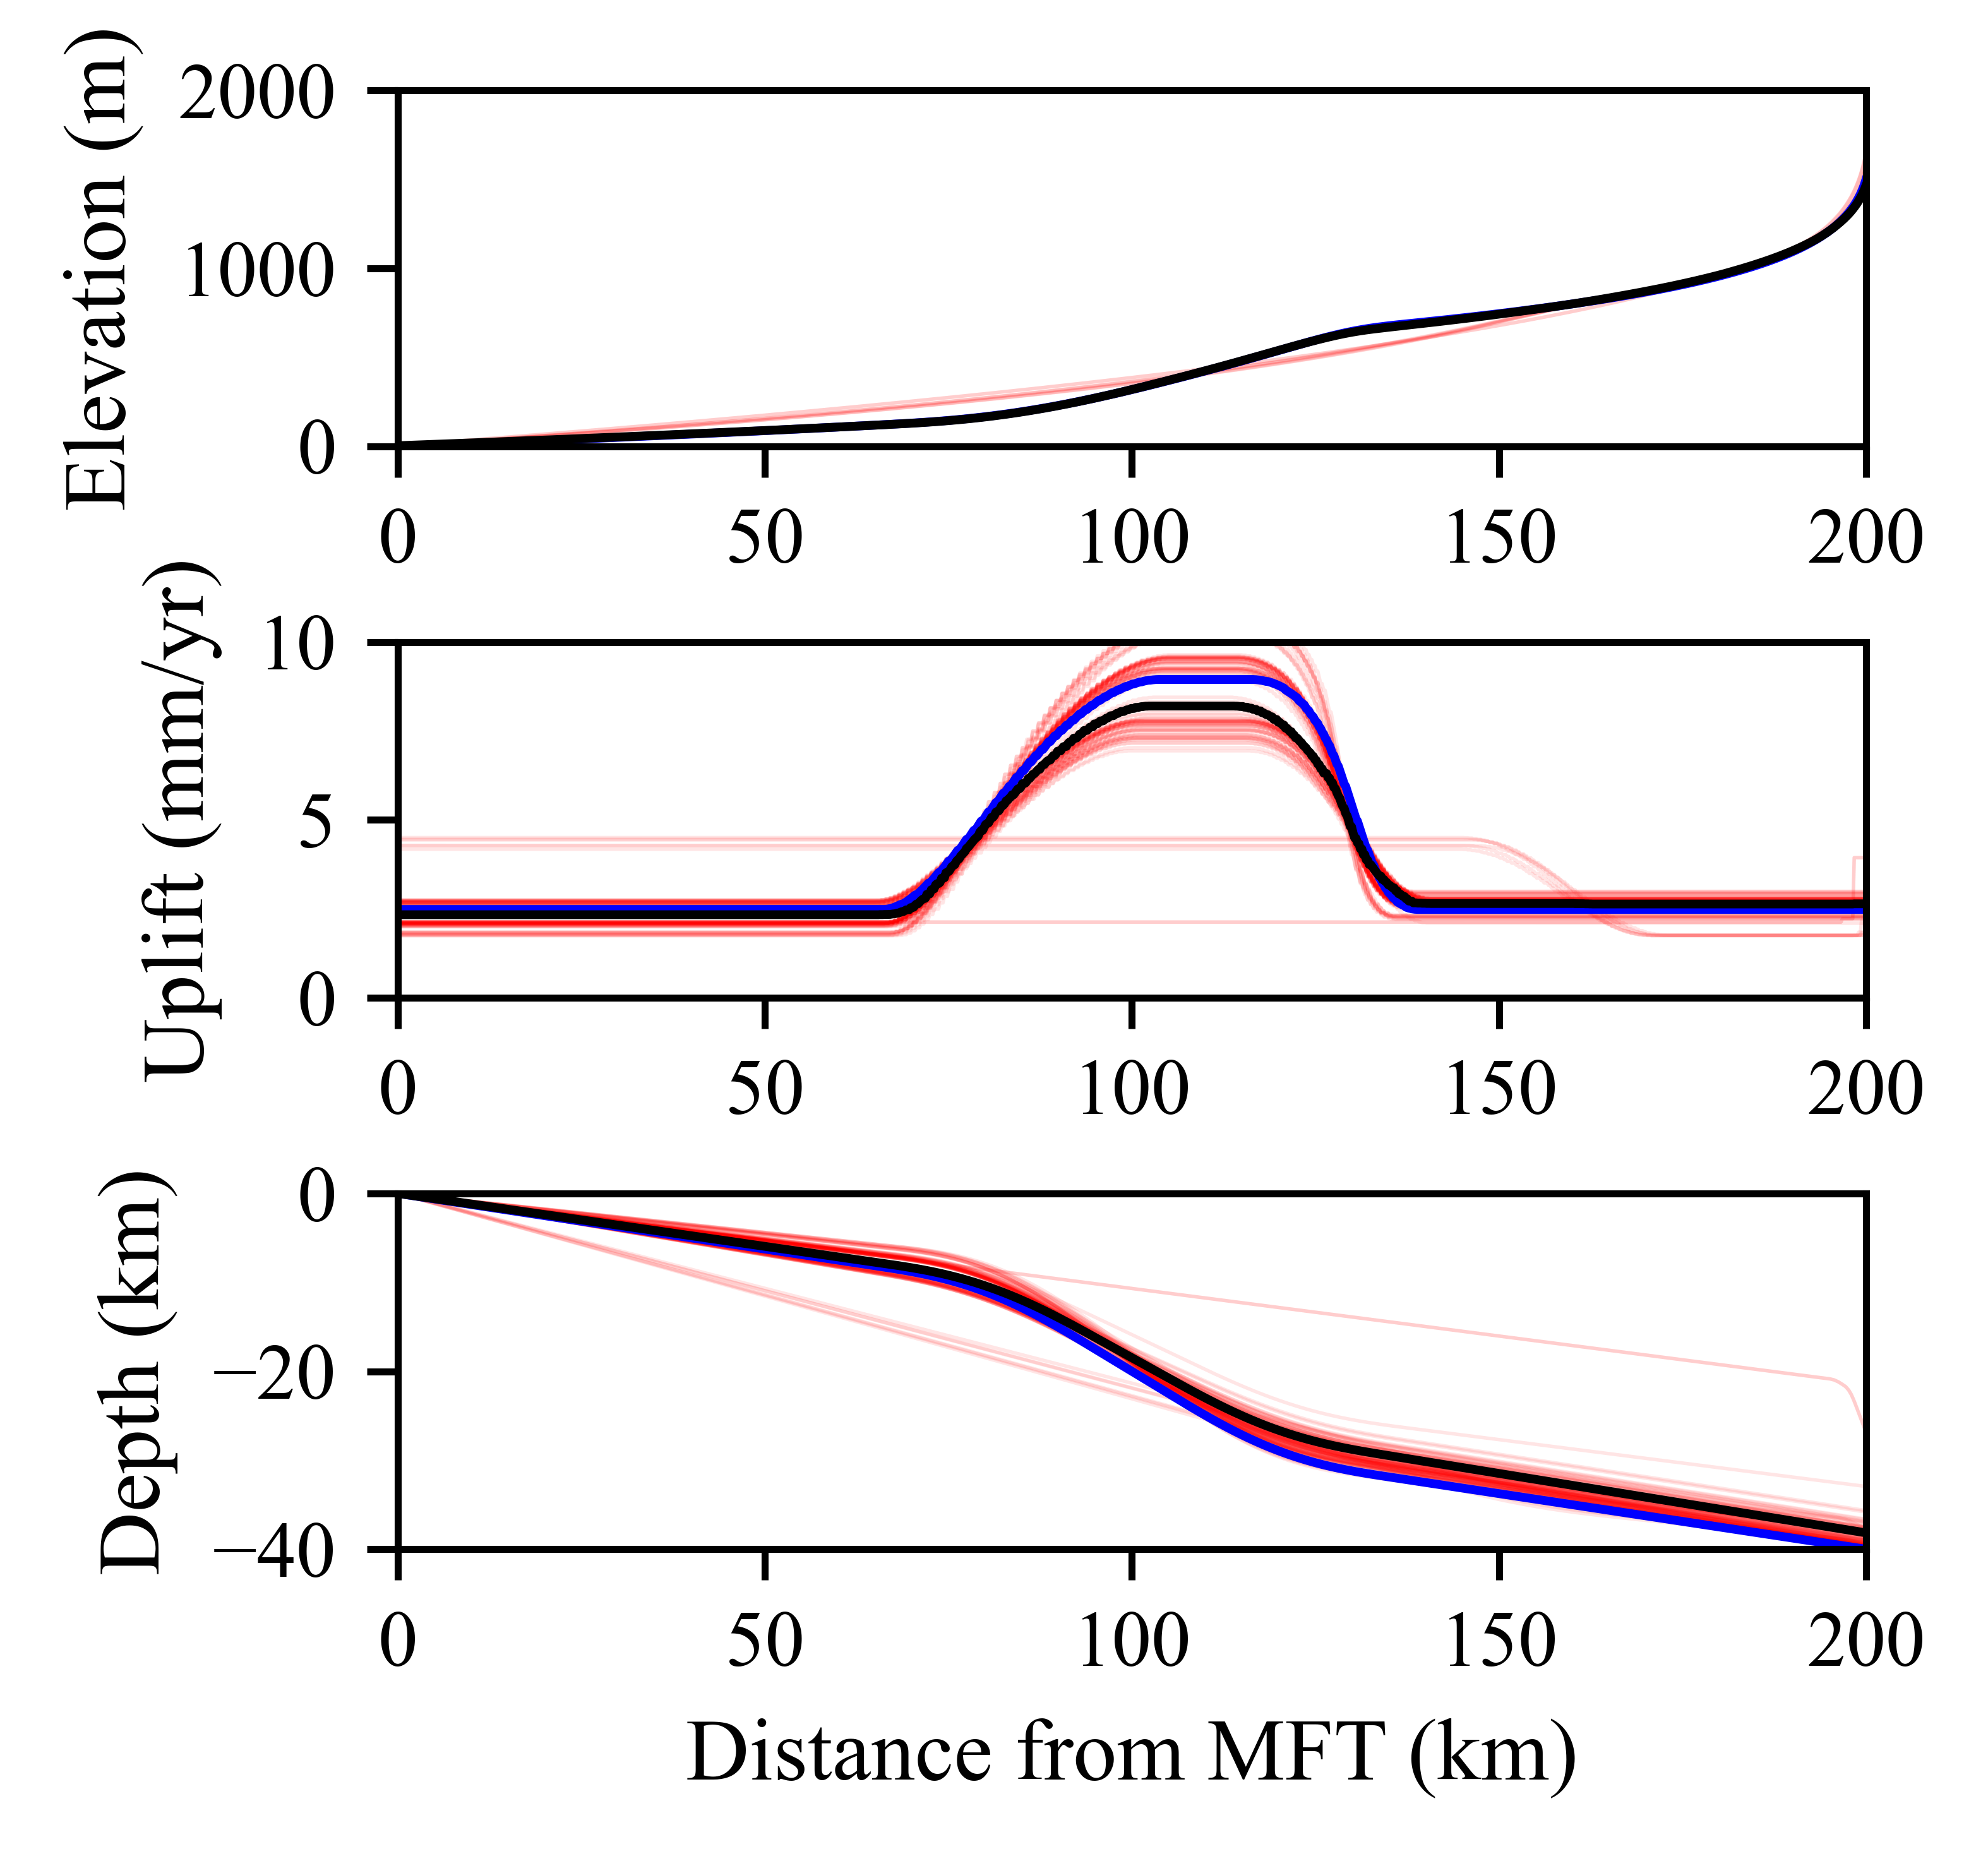

In [14]:
fig = plt.figure(figsize=(3,3))
gs = fig.add_gridspec(3, 1, hspace=0.55)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])

for j in range(len(pred_draws)):
    ax1.plot(s_km, pred_draws[j], "r-", lw=0.4, alpha=0.10)
    ax2.plot(x_master, uplift_draws[j], "r-", lw=0.4, alpha=0.10)
    xnode, znode = fault_draws[j]
    ax3.plot(xnode, znode, "r-", lw=0.4, alpha=0.10)

ax1.plot(s_km, Z_true, "b-", lw=1.0, label="truth")
ax2.plot(x_master, uplift_true, "b-", lw=1.0, label="truth")
ax3.plot(xnode_T, znode_T, "b-", lw=1.0, label="truth")

ax1.plot(s_km, z_med, "k-", lw=1, label="posterior median")
ax2.plot(x_master, u_med, "k-", lw=1, label="posterior median")
ax3.plot(best_med["xnode"], best_med["znode"], "k-", lw=1, label="median-parameter")

# --- Formatting
ax1.set_ylabel("Elevation (m)")
ax2.set_ylabel("Uplift (mm/yr)")
ax3.set_xlabel("Distance from MFT (km)")
ax3.set_ylabel("Depth (km)")

ax3.set_ylim([-40, 0])
ax2.set_ylim([0, 10])
ax1.set_ylim([0, 2000])

ax1.set_xlim([0, 200])
ax2.set_xlim([0, 200])
ax3.set_xlim([0, 200])

plt.tight_layout()
plt.show()
